In [83]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

C:\Users\sanfe\AppData\Local\Temp\ipykernel_19384\1562700421.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


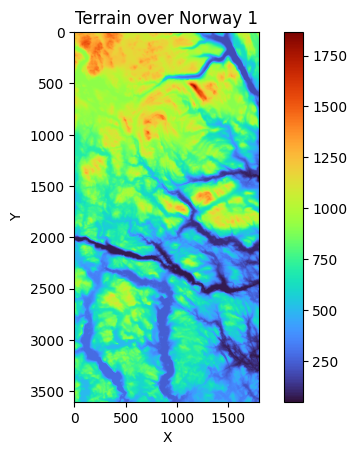

In [76]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap="turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()

In [22]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

In [44]:
#create design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2)/n

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [57]:
# Create a meshgrid of coordinates that match the shape of the terrain data
x = np.linspace(0, 1, terrain1.shape[0])
y = np.linspace(0, 1, terrain1.shape[1])
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = terrain1.ravel()

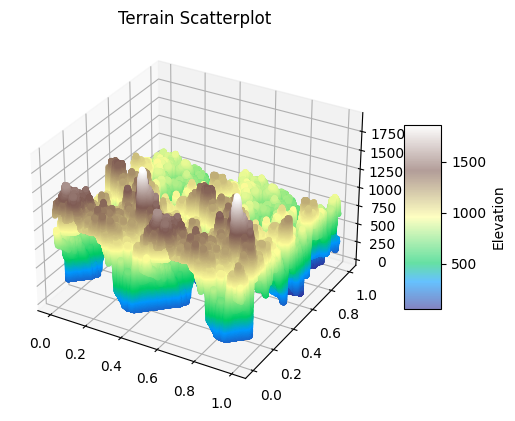

In [58]:
# Create a 3D scatter plot for the terrain data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Terrain Scatterplot')

# Flatten the arrays for the scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
terrain_flat = terrain1.flatten()

# Create the scatter plot
sc = ax.scatter(x_flat, y_flat, terrain_flat, c=terrain_flat, cmap="terrain", s=10, alpha=0.6)

# Add a color bar which maps values to colors
cbar = fig.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Elevation')

plt.show()

TypeError: Colorbar.__init__() got an unexpected keyword argument 'cbar'

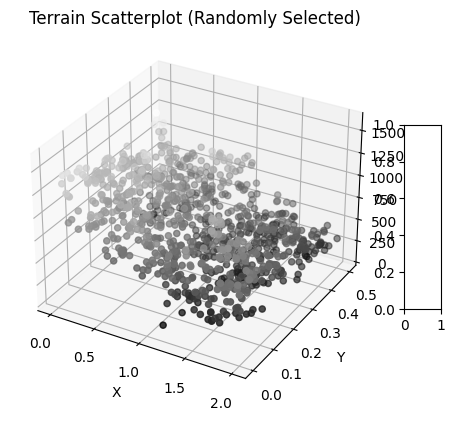

In [75]:
# Randomly select 1000 coordinates
random_indices = np.random.choice(terrain1.size, num_points, replace=False)
x_indices, y_indices = np.unravel_index(random_indices, terrain1.shape)

# Extract the elevation values at the selected coordinates
elevation_values = terrain1[x_indices, y_indices]

# Create a meshgrid of coordinates for the selected points
x_selected = x_indices / (terrain1.shape[1] - 1)
y_selected = y_indices / (terrain1.shape[0] - 1)

# Create a 3D scatter plot for the selected points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Terrain Scatterplot (Randomly Selected)')

# Create the scatter plot
sc = ax.scatter(x_selected, y_selected, elevation_values, c = elevation_values, cmap='gray')

# Customize the axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Terrain Elevation')

# Add a color bar which maps values to colors
cbar = fig.colorbar(sc, shrink=0.5, aspect=5, cbar = "")
cbar.set_label('Elevation')

plt.show()

In [ ]:
# Create a meshgrid of coordinates that match the shape of the terrain data
x = np.linspace(0, 1, terrain1.shape[0])
y = np.linspace(0, 1, terrain1.shape[1])
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = terrain1.ravel()

In [88]:
n = 5
N = len(x)

# setup for Cross-validation
maxdeg = 20
degrees = np.arange(1, maxdeg+1, dtype=int)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((maxdeg, k))
scores_KFold_test = np.zeros((maxdeg, k))

fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(degrees):
    # Generate design matrix
    X = create_X(x, y, deg)
    # Divide in test and train data
    X_train, X_test, z_train, z_test = train_test_split(x, y, test_size=0.2)

    j = 0
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    z_train_scaled = scaler.fit_transform(z_train)
    z_test_scaled = scaler.fit_transform(z_test)
        
    ols_linreg = LinearRegression(fit_intercept = True)
    ols_linreg.fit(X_train_scaled, z_train_scaled)
    scores_KFold_train[i, j] = MSE(X_train_scaled, z_train_scaled)
    scores_KFold_test[i, j] = MSE(X_test_scaled, z_test_scaled)
        
    j += 1
    
estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.3)
plt.plot(degrees, estimated_mse_KFold_train, label='Train MSE')
plt.plot(degrees, estimated_mse_KFold_test, label='Test MSE')
plt.legend()
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title(r'K-fold Cross Validation, k = 5, slice index = 10')
plt.show()

KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

**OLS**

In [85]:
betaOLS = (np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T ) @ z_train_scaled
interceptOLS = z_scaler - X_train_mean @ betaOLS

# Make the prediction
ztildeOLS = X_train_scaled @ betaOLS + z_scaler
zpredictOLS = X_test_scaled @ betaOLS + z_scaler

#MSE and R2
print("MSE train OLS: ")
print(MSE(z_train, ztildeOLS))
print("R2 train OLS: ")
print(R2(z_train, ztildeOLS))
print("MSE test OLS: ")
print(MSE(z_test, zpredictOLS))
print("R2 test OLS: ")
print(R2(z_test, zpredictOLS))

MSE train OLS: 
51584.43134397743
R2 train OLS: 
0.43987768949355044
MSE test OLS: 
51544.52711620744
R2 test OLS: 
0.44073083058362406
